# Prepare the Data
Author: Amaris Williams, PhD

Date: October 2025

This analysis is loosely based on https://doi.org/10.21203/rs.3.rs-7509723/v1
### Set Up Environment

In [1]:
# set up environment
from IPython.display import Image
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib

sns.set_style('darkgrid')

### Study Design -- 2 x 2 Factorial

In [2]:
Image(url="https://www.statology.org/wp-content/uploads/2021/05/2x2_1.png", 
      width=300, height=300)

**Research Question:** what feature set allows a long short-term memory (LSTM) model to most accurately predict future volatility of the S&P 500 index at 1-, 5-, and 22-day windows?

**Study Sesign:** Two-by-two factorial (see image above).

Two characteristics of the feature set will be tested: **Independent Variable 1:** whether implied volatility is included (^VIX) and **Independent Variable 2:** whether the technical features of each sector of the S&P 500 are considered separately or if only the technical features of the index as a whole (^SPX) are included. This will result in 4 feature sets:
* **Feature Set 1:** technical features of ^SPX with ^VIX
* **Feature Set 2:** technical features of ^SPX without ^VIX
* **Feature Set 3:** technical features of each S&P 500 sector with ^VIX
* **Feature Set 4:** technical features of each S&P 500 sector without ^VIX

**Dependent Variables:** volatility of the S&P 500 index at 1-, 5-, and 22-day windows

### Download Sector and Index Price Data and Volume

In [3]:
# TR indicates 'total return', where dividends are reinvested into the index
tickers = ['^SP500-50',  # Communication Services
           '^SP500-25',  # Consumer Discretionary
           '^SP500-30',  # Consumer Staples
           '^GSPE',  # Energy
           '^SP500-40',  # Financials
           '^SP500-35',  # Health Care
           '^SP500-20',  # Industrials
           '^SP500-45',  # Information Technology
           '^SP500-15',  # Materials
           '^SP500-60',  # Real Estate
           '^SP500-55',  # Utilities
           '^SPX']  # the S&P 500 index marker

In [4]:
df = yf.download(list(tickers), start = "2010-01-01") # > 15 years' history

/tmp/ipykernel_3386/1751202617.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers), start = "2010-01-01") # > 15 years' history
[*********************100%***********************]  12 of 12 completed


In [5]:
# We only need the closing price ('Close') and volume ('Volume') columns
print(df.shape)
dfidx = pd.MultiIndex.from_product([["Close","Volume"], list(tickers)], names=['Price', 'Ticker'])
df = df[dfidx]
print(df.shape)

(3970, 60)
(3970, 24)


### Add implied volatility to the mix

In [6]:
impvol = yf.download("^VIX", start = "2010-01-01")  # measure of implied volatility of S&P 500
impvol = impvol[("High","^VIX")]
df = pd.concat([df,impvol], axis = 1)
df.iloc[0:10].xs('^VIX', axis=1, level=1, drop_level=False)
del impvol

/tmp/ipykernel_3386/275217642.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  impvol = yf.download("^VIX", start = "2010-01-01")  # measure of implied volatility of S&P 500
[*********************100%***********************]  1 of 1 completed


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df

Close                                                   \
             ^SP500-50    ^SP500-25   ^SP500-30       ^GSPE   ^SP500-40   
Date                                                                      
2010-01-04  116.260002   236.460007  277.000000  442.079987  197.789993   
2010-01-05  116.639999   237.619995  276.700012  445.600006  201.149994   
2010-01-06  113.169998   237.589996  276.350006  450.200012  202.000000   
2010-01-07  112.209999   239.630005  276.279999  449.200012  206.210007   
2010-01-08  111.699997   239.600006  274.869995  451.470001  205.089996   
...                ...          ...         ...         ...         ...   
2025-10-09  418.040009  1901.760010  867.039978  671.830017  886.969971   
2025-10-10  408.390015  1839.119995  869.219971  653.020020  867.780029   
2025-10-13  415.700012  1881.239990  866.070007  662.309998  875.960022   
2025-10-14  416.660004  1876.400024  880.950012  661.859985  885.739990   
2025-10-15         NaN          NaN         NaN         NaN         NaN   

                                                                           \
              ^SP500-35    ^SP500-20    ^SP500-45   ^SP500-15   ^SP500-60   
Date                                                                        
2010-01-04   367.260010   247.110001   376.459991  205.360001   93.790001   
2010-01-05   365.149994   247.990005   376.329987  206.429993   94.040001   
2010-01-06   366.890015   248.490005   373.029999  209.570007   93.839996   
2010-01-07   368.260010   251.720001   371.600006  208.610001   94.949997   
2010-01-08   369.350006   255.559998   374.529999  210.750000   93.720001   
...                 ...          ...          ...         ...         ...   
2025-10-09  1681.979980  1297.729980  5746.009766  563.830017  258.380005   
2025-10-10  1657.000000  1268.859985  5517.859863  553.549988  255.479996   
2025-10-13  1655.569946  1282.109985  5654.270020  562.260010  256.750000   
2025-10-14  1660.010010  1297.150024  5564.089844  567.150024  259.470001   
2025-10-15          NaN          NaN          NaN         NaN         NaN   

                                          Volume                            \
             ^SP500-55         ^SPX    ^SP500-50    ^SP500-25    ^SP500-30   
Date                                                                         
2010-01-04  158.240005  1132.989990  105275800.0    3887400.0  169185300.0   
2010-01-05  156.509995  1136.520020  213872700.0    6158000.0  215267900.0   
2010-01-06  157.279999  1137.140015  217111100.0    5972600.0  227513200.0   
2010-01-07  156.429993  1141.689941  215949800.0    6662800.0  204194200.0   
2010-01-08  156.229996  1144.979980  115506000.0    4957800.0  181266100.0   
...                ...          ...          ...          ...          ...   
2025-10-09  459.929993  6735.109863  245729800.0  348063600.0  228730800.0   
2025-10-10  457.899994  6552.509766  279298300.0  456001600.0  242828000.0   
2025-10-13  461.329987  6654.720215  208483200.0  353001700.0  229303200.0   
2025-10-14  465.570007  6644.310059  209338600.0  378025400.0  235817000.0   
2025-10-15         NaN          NaN          NaN          NaN          NaN   

                                                                              \
                  ^GSPE    ^SP500-40    ^SP500-35    ^SP500-20     ^SP500-45   
Date                                                                           
2010-01-04  232188400.0   10388600.0    2439600.0    1995400.0  6.424600e+06   
2010-01-05  260360000.0   14246400.0    2644200.0    2189800.0  7.697800e+06   
2010-01-06  276306700.0   13299600.0    2564000.0    2165600.0  6.725000e+06   
2010-01-07  202070700.0   16667200.0    2661200.0    3586200.0  7.243400e+06   
2010-01-08  209658700.0   12853000.0    2483200.0    2748000.0  6.720200e+06   
...                 ...          ...          ...          ...           ...   
2025-10-09  138511200.0  340732200.0  206040100.0  210162300.0  7.698873e+

### Save Downloaded Data

In [8]:
print(df.shape)
path = "/home/anw/Documents/Python/Data/"
df.to_csv(str(path) + "snp500sectorsunprocessed.csv", index = True)

(3971, 25)


### Visualize Data

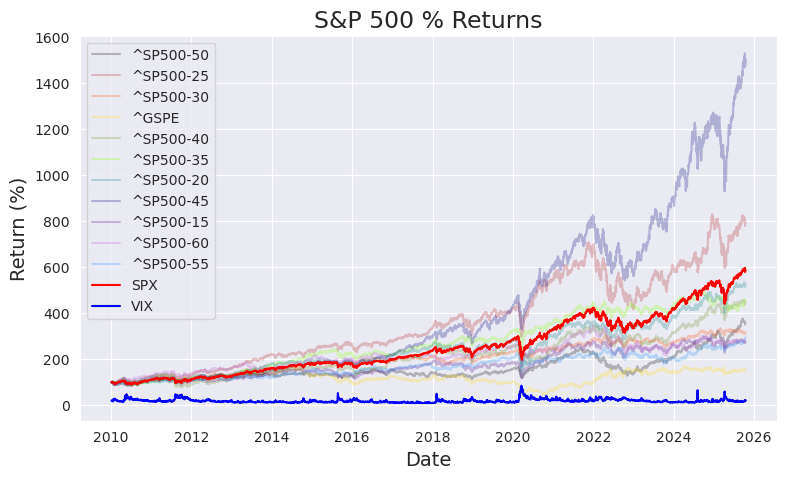

In [9]:
# Visual of daily sector % returns

colors = ['black','firebrick','orangered','gold',
          'olivedrab','chartreuse','teal','navy',
          'indigo','mediumorchid','dodgerblue']

plt.figure(figsize = (9,5))
plt.title('S&P 500 % Returns', size = 17)

k = 0
for ticker in tickers[:len(tickers)-1]:
    plt.plot(df['Close',ticker] * 100 / df['Close',ticker].iloc[0], 
             color = colors[k], alpha = 0.25, label = ticker)
    k += 1

plt.plot(df['Close','^SPX'] * 100 / df['Close','^SPX'].iloc[0], 
         color = 'red', label = 'SPX')
plt.plot(df['High','^VIX'], color = 'blue', label = 'VIX')
plt.legend()

plt.xlabel('Date', size = 14)
plt.ylabel('Return (%)', size = 14)

plt.show()

### Handle Missing Values

In [10]:
# path = "/home/anw/Documents/Python/Data/"
# df = pd.read_csv(str(path) + "snp500sectorsunprocessed.csv", header = [0,1], index_col = 0)


In [11]:
# Check for missings
print(df.shape)  # whole data frame
print(df.dropna(axis=1, how='all').shape)  # check for a column of all missing values
print(df.dropna(axis=1, how='all').dropna().shape)  # check how many rows are missing values
# if all numbers the same, then no missings!!

(3971, 25)
(3971, 25)
(3967, 25)


In [12]:
# What is missing and when?
df.loc[df.isna().sum(axis = 1) > 0,:]

Close                                                      \
           ^SP500-50 ^SP500-25 ^SP500-30       ^GSPE ^SP500-40 ^SP500-35   
Date                                                                       
2019-07-01       NaN       NaN       NaN  471.739990       NaN       NaN   
2019-07-02       NaN       NaN       NaN  463.540009       NaN       NaN   
2019-07-03       NaN       NaN       NaN  463.540009       NaN       NaN   
2025-10-15       NaN       NaN       NaN         NaN       NaN       NaN   

                                                                               \
           ^SP500-20 ^SP500-45   ^SP500-15   ^SP500-60 ^SP500-55         ^SPX   
Date                                                                            
2019-07-01       NaN       NaN  369.660004  227.259995       NaN  2964.330078   
2019-07-02       NaN       NaN  369.149994  231.389999       NaN  2973.010010   
2019-07-03       NaN       NaN  371.019989  234.789993       NaN  2995.820068   
2025-10-15       NaN       NaN         NaN         NaN       NaN          NaN   

              Volume                                                       \
           ^SP500-50 ^SP500-25 ^SP500-30        ^GSPE ^SP500-40 ^SP500-35   
Date                                                                        
2019-07-01       NaN       NaN       NaN  151863100.0       NaN       NaN   
2019-07-02       NaN       NaN       NaN  178358300.0       NaN       NaN   
2019-07-03       NaN       NaN       NaN   82408100.0       NaN       NaN   
2025-10-15       NaN       NaN       NaN          NaN       NaN       NaN   

                                                                   \
           ^SP500-20 ^SP500-45    ^SP500-15   ^SP500-60 ^SP500-55   
Date                                                                
2019-07-01       NaN       NaN  110744500.0  62278500.0       NaN   
2019-07-02       NaN       NaN   83723100.0  56982900.0       NaN   
2019-07-03       NaN       NaN   43217300.0  26185900.0       NaN   
2025-10-15       NaN       NaN          NaN         NaN       NaN   

                           High  
                    ^SPX   ^VIX  
Date                             
2019-07-01  3.524860e+09  14.64  
2019-07-02  3.224490e+09  14.30  
2019-07-03  1.963570e+09  13.19  
2025-10-15           NaN  20.10

In [13]:
# remove or replace missings
df.dropna(inplace = True)

### Create Technical Variables

In [14]:
# I created all variables in all windows with the ^SPX ticker,
# then changed the code to only calculate the least correlated
# X variables and outcome variables of interest for efficiency.
# cuttoff used: abs(corr) < 0.8

df = df.sort_values("Date")

tickers = list(df.columns.get_level_values(1).unique())
tickers.remove('^VIX')

for ticker in tickers:
    newcols = pd.MultiIndex.from_tuples([('log_ret1', ticker),('sigma_roll1', ticker),
                                         ('log_ret5', ticker),
                                         ('sigma_roll5', ticker),('log_ret22', ticker),
                                         ('sigma_roll22', ticker),('log_ret66', ticker),
                                         ('log_ret132', ticker),('sigma_roll132', ticker)],
                                        names=['Price', 'Ticker'])
    newfeatures = pd.DataFrame(np.zeros((df.shape[0],len(newcols))), index = df.index, columns = newcols)
    for window in [1,5,22,66,132]: # daily, weekly, monthly, 3-month, 6-month features
        # basic return features
        newfeatures.loc[:,(f'log_ret{window}', ticker)] = np.log(df['Close'][ticker] / df['Close'][ticker].shift(window))
        
        if window in [1,5,22,132]:
            # calculate sigma based on Oliveira & Costa (2025) Equation 6
            newfeatures[f'sigma_roll{window}',ticker] = np.sqrt(newfeatures['log_ret1',ticker].pow(2).rolling(window).mean())
            if (window != 132) & (ticker == '^SPX'): # calculate outcome columns
                newfeatures[f'fut_sigma_{window}',ticker] = newfeatures[f'sigma_roll{window}',ticker].shift(window*(-1))

    
    df = pd.concat([df,newfeatures],axis = 1)
        
    df = df.copy()




In [15]:
df.xs('^SPX', axis=1, level=1, drop_level=False).iloc[0:10]

,Close,Volume,log_ret1,sigma_roll1,log_ret5,sigma_roll5,log_ret22,sigma_roll22,log_ret66,log_ret132,sigma_roll132,fut_sigma_1,fut_sigma_5,fut_sigma_22
,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,,,,,,,,,,
2010-01-04,1132.989990,3.991400e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003111,0.002729,0.011972
2010-01-05,1136.520020,2.491020e+09,0.003111,0.003111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000545,0.004825,0.011970
2010-01-06,1137.140015,4.972660e+09,0.000545,0.000545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003993,0.006080,0.012119
2010-01-07,1141.689941,5.270680e+09,0.003993,0.003993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002878,0.005912,0.012400
2010-01-08,1144.979980,4.389590e+09,0.002878,0.002878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001745,0.007549,0.012394
2010-01-11,1146.979980,4.255780e+09,0.001745,0.001745,0.012272,0.002729,NaN,NaN,NaN,NaN,NaN,0.009425,0.009340,0.012558
2010-01-12,1136.219971,4.716160e+09,-0.009425,0.009425,-0.000264,0.004825,NaN,NaN,NaN,NaN,NaN,0.008291,0.009601,0.012410
2010-01-13,1145.680054,4.170360e+09,0.008291,0.008291,0.007482,0.006080,NaN,NaN,NaN,NaN,NaN,0.002423,0.012312,0.012859


### Check | Correlation Coefficient | < 0.8 

Features used in modeling should not be highly correlated.

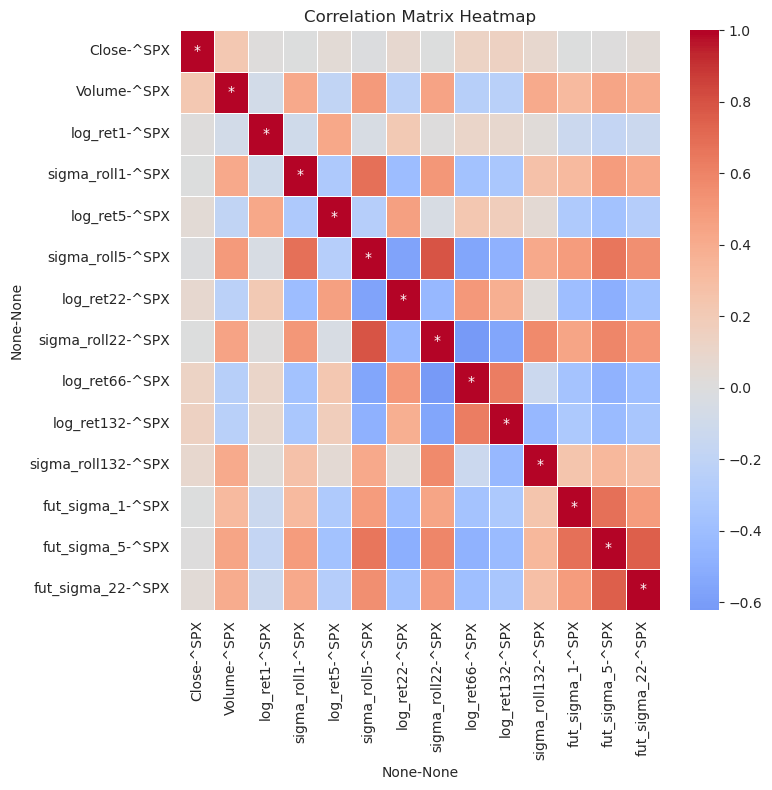

In [16]:
# 1. Compute a correlation matrix
corr_matrix = df.xs('^SPX', axis=1, level=1, drop_level=False).corr()

# where is the correlation too high?
mask_star = corr_matrix.abs() >= 0.8
annot = np.where(mask_star, '*', '')

# 2. Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_matrix,
    annot=annot,        # asterisks
    fmt="",         
    cmap='coolwarm',   # color map
    center=0,          # center colormap at 0
    linewidths=0.5     # line width between cells
)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

### Save Data Frame with Technical Features

In [17]:
df.to_csv(str(path) + "snp500sectorswithaddedfeatures.csv", index = True)

### Pre-process data

In [2]:
# path = "/home/anw/Documents/Python/Data/"
# df = pd.read_csv(str(path) + "snp500sectorswithaddedfeatures.csv", 
#                  header = [0,1], index_col = 0)
print(df.shape)
df.dropna(inplace=True) # will remove first 6 months' worth of data and last 22 trading days' data
print(df.shape)


(3967, 136)
(3813, 136)


In [5]:
def scalefs(fstrain, fstest, negs, path = None, filename = None):
    """
    fstrain (DataFrame with multi index)
    fstest (DataFrame with multi index)
    negs: list of columns with negative numbers
    path: optional string of the path where the 
        scaler models will be saved
    filename: optional string for the base name of the 
        scaler model that will be saved for later use
    
    negs are scaled to a range of -1 to 1. 
    The remaining columns are 
    scaled to 0 to 1.
    """
    # different scaler for coumns with negative numbers
    negscaler = MinMaxScaler(feature_range=(-1, 1))
    posscaler = MinMaxScaler(feature_range=(0, 1))  # positive numbers only
    
    # fit for negative numbers
    tickers = list(fstrain.columns.get_level_values(1).unique())
    if '^VIX' in tickers:
        tickers.remove('^VIX')
    negcols = pd.MultiIndex.from_product([negs, list(tickers)], names=['Price', 'Ticker'])
    fstrain.loc[:, negcols] = negscaler.fit_transform(fstrain[negcols])
    fstest.loc[:, negcols] = negscaler.transform(fstest[negcols])
        
    # fit for positive numbers
    poscols = fstrain.columns[~fstrain.columns.isin(negcols)]
    fstrain.loc[:, poscols] = posscaler.fit_transform(fstrain[poscols])
    fstest.loc[:, poscols] = posscaler.transform(fstest[poscols])

    if (path is not None) & (filename is not None):
        joblib.dump(posscaler, str(path) + str(filename) + 'pos.gz')
        joblib.dump(negscaler, str(path) + str(filename) + 'neg.gz')
    
    
    return fstrain, fstest


In [6]:
# Split outcome (future sigma at 1, 5, and 22 days) and X variables
y = df[[("fut_sigma_1","^SPX"),("fut_sigma_5","^SPX"),
        ("fut_sigma_22","^SPX")]]
X = df.drop([("fut_sigma_1","^SPX"),("fut_sigma_5","^SPX"),
             ("fut_sigma_22","^SPX")], axis = 1)

# Split into train and test sets
train_size = int(len(df) * 0.85)
Xtrain, Xtest = X[:train_size], X[train_size:]
ytrain, ytest = y[:train_size], y[train_size:]

# create the four feature sets (train and test)
# Feature Set 1: technical features of ^SPX with ^VIX
fs1train = pd.concat([Xtrain.xs('^SPX', axis=1, level=1, drop_level=False),
                      Xtrain.xs('^VIX', axis=1, level=1, drop_level=False)],
                     axis = 1)
fs1test = pd.concat([Xtest.xs('^SPX', axis=1, level=1, drop_level=False),
                      Xtest.xs('^VIX', axis=1, level=1, drop_level=False)],
                     axis = 1)
# Feature Set 2: technical features of ^SPX without ^VIX
fs2train = Xtrain.xs('^SPX', axis=1, level=1, drop_level=False)
fs2test = Xtest.xs('^SPX', axis=1, level=1, drop_level=False)
# Feature Set 3: technical features of each S&P 500 sector with ^VIX
fs3train = Xtrain.drop('^SPX', axis=1, level = 1)
fs3test = Xtest.drop('^SPX', axis=1, level = 1)
# Feature Set 4: technical features of each S&P 500 sector without ^VIX
fs4train = Xtrain.drop(['^SPX','^VIX'], axis=1, level = 1)
fs4test = Xtest.drop(['^SPX','^VIX'], axis=1, level = 1)

    
# scale all variables
negs = ['log_ret1','log_ret5','log_ret22',
        'log_ret1','log_ret66','log_ret132']
fs1train, fs1test = scalefs(fs1train, fs1test, negs)
fs2train, fs2test = scalefs(fs2train, fs2test, negs)
fs3train, fs3test = scalefs(fs3train, fs3test, negs)
fs4train, fs4test = scalefs(fs4train, fs4test, negs)

# fit for outcome columns
yscaler = MinMaxScaler(feature_range=(0, 1))
ytrain = yscaler.fit_transform(pd.DataFrame(ytrain))
ytest = yscaler.transform(pd.DataFrame(ytest))



### Save y scaling object

In [7]:
joblib.dump(yscaler, str(path) + 'yscaler.gz')


['/home/anw/Documents/Python/Data/yscaler.gz']

### Save Prepared Data

In [37]:
fs1train.to_csv(str(path) + "fs1train.csv", index = True)
fs1test.to_csv(str(path) + "fs1test.csv", index = True)
fs2train.to_csv(str(path) + "fs2train.csv", index = True)
fs2test.to_csv(str(path) + "fs2test.csv", index = True)
fs3train.to_csv(str(path) + "fs3train.csv", index = True)
fs3test.to_csv(str(path) + "fs3test.csv", index = True)
fs4train.to_csv(str(path) + "fs4train.csv", index = True)
fs4test.to_csv(str(path) + "fs4test.csv", index = True)


In [8]:
np.save(str(path) + "snp500sectorsytrain.npy", ytrain)
np.save(str(path) + "snp500sectorsytest.npy", ytest)
